In [1]:
import math

import re

import time

from google.colab import drive

In [2]:
try:
    %tensorflow_version 2.x
except:
    pass
import tensorflow as tf

from tensorflow.keras import layers

import tensorflow_datasets as tfds

In [3]:
import pandas as pd

import numpy as np

import h5py

from gensim.models import Word2Vec

import gensim.models

from tensorflow import keras

from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential

from sklearn.metrics import roc_auc_score

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Embedding

from tensorflow.keras.layers import Dropout

from tensorflow.keras.layers import Activation

from tensorflow.keras.layers import Bidirectional

from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import SimpleRNN

from tensorflow.keras.layers import GRU

from tensorflow.keras.preprocessing.sequence import pad_sequences 

import re

from nltk.tokenize import word_tokenize

import nltk

from nltk.corpus import stopwords 

nltk.download('stopwords')

nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [6]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [7]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [8]:
data_clickbait = pd . read_csv ('/content/drive/My Drive/clickbait_data' , sep = ' \ n ' , header = None )

data_noclickbait = pd . read_csv ('/content/drive/My Drive/non_clickbait_data' , sep = ' \ n ' , header = None )

data_clickbait = data_clickbait.sample(frac = 7.5/16)

data_noclickbait = data_noclickbait.sample(frac = 7.5/16)

data_clickbait['class'] = [1 for i in range(7500)]

data_noclickbait['class'] = [0 for i in range(7500)] 

data_Final = pd . concat (( data_clickbait , data_noclickbait ), ignore_index = True ) 

df = data_Final . rename ( columns = { 0 : "text" })

df = df . sample ( frac = 1 ). reset_index ( drop = True )

print (df.shape)

print (df.head(5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


(15000, 2)
                                                text  class
0          Doctors Face Fiscal Squeeze for Treatment      0
1  Controversy after leak of preliminary report i...      0
2  19 Of The Stupidest Ways People Have Broken Th...      1
3  18 Insanely Cute Gifts You Should Buy "Your Pe...      1
4  Tibetans demand that China release Panchen Lam...      0


In [9]:
data_clickbait['class'] = [1 for i in range(7500)]

data_noclickbait['class'] = [0 for i in range(7500)] 

In [10]:
df

,text,class
0,Doctors Face Fiscal Squeeze for Treatment,0
1,Controversy after leak of preliminary report i...,0
2,19 Of The Stupidest Ways People Have Broken Th...,1
3,"18 Insanely Cute Gifts You Should Buy ""Your Pe...",1
4,Tibetans demand that China release Panchen Lam...,0
...,...,...
14995,"Egyptian billionaire MP, former policeman to h...",0
14996,Wall Street Closes Lower as Global Forecast Dims,0
14997,19 Heartbreaking Confessions About Being Addic...,1
14998,Declassified records show American inaction du...,0


In [11]:
#### WORD2VEC_VECTORS_BIN  =  '/content/drive/My Drive/GoogleNews-vectors-negative300.bin'

#### w2v  =  gensim . models . KeyedVectors . load_word2vec_format ( WORD2VEC_VECTORS_BIN , binary = True )

In [12]:
stop_words  =  set ( stopwords . words ( 'english' ))

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
L = []
for  i , token  in  enumerate ( df [ 'text' ]):
    words = [ w  for  w  in  token . split () if  not  w  in  stop_words ]
    L . append ( len ( words ))
    
sequence_size = max ( L )

## separate data non-randomly to avoid having a problem during cross validation due to indexes

X = df['text']

y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.2, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 42)

In [15]:
y_train = np.array(y_train)

y_test = np.array(y_test)

y_val = np.array(y_val)

In [16]:
y_train.shape

(9000,)

In [17]:
from keras.preprocessing.text import Tokenizer 

tokenizer = Tokenizer(num_words = sequence_size)

tokenizer.fit_on_texts(X_train)

sequences = tokenizer.texts_to_sequences(X_train)

train_data = pad_sequences(sequences, maxlen = sequence_size , padding='post')

tokenizer.fit_on_texts(X_test)

sequences = tokenizer.texts_to_sequences(X_test)

test_data = pad_sequences(sequences, maxlen = sequence_size , padding='post')

sequences = tokenizer.texts_to_sequences(X_val)

val_data = pad_sequences(sequences, maxlen = sequence_size , padding='post')

Using TensorFlow backend.


In [18]:
embed_dim = 300  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32

inputs = layers.Input(shape = (sequence_size,))

embedding_layer = TokenAndPositionEmbedding(sequence_size,len(tokenizer.word_index) + 1 , embed_dim)

x = embedding_layer(inputs)

transformer_block = TransformerBlock(300, num_heads, ff_dim)

x = transformer_block(x)

x = layers.GlobalAveragePooling1D()(x)

x = layers.Dropout(0.1)(x)

x = layers.Dense(512, activation="sigmoid")(x)

x = layers.Dropout(0.1)(x)

x = layers.Dense(256, activation="relu")(x)

x = layers.Dropout(0.1)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs = inputs, outputs = outputs)

model.summary()

model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 26)]              0         
_________________________________________________________________
token_and_position_embedding (None, 26, 300)           4519500   
_________________________________________________________________
transformer_block (Transform (None, 26, 300)           381932    
_________________________________________________________________
global_average_pooling1d (Gl (None, 300)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               154112    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0     

In [19]:
history = model.fit(train_data , y_train , batch_size = 64 , epochs = 20 , validation_data = (val_data , y_val), verbose = 1)

Epoch 1/20
141/141 [==============================] - 7s 53ms/step - loss: 0.5539 - accuracy: 0.6926 - val_loss: 0.4502 - val_accuracy: 0.8197
Epoch 2/20
141/141 [==============================] - 7s 50ms/step - loss: 0.3737 - accuracy: 0.8454 - val_loss: 0.4760 - val_accuracy: 0.8173
Epoch 3/20
141/141 [==============================] - 7s 50ms/step - loss: 0.3689 - accuracy: 0.8457 - val_loss: 0.5179 - val_accuracy: 0.8163
Epoch 4/20
141/141 [==============================] - 7s 49ms/step - loss: 0.3669 - accuracy: 0.8451 - val_loss: 0.5091 - val_accuracy: 0.8173
Epoch 5/20
141/141 [==============================] - 7s 49ms/step - loss: 0.3642 - accuracy: 0.8461 - val_loss: 0.4914 - val_accuracy: 0.8193
Epoch 6/20
141/141 [==============================] - 7s 50ms/step - loss: 0.3610 - accuracy: 0.8486 - val_loss: 0.5535 - val_accuracy: 0.8203
Epoch 7/20
141/141 [==============================] - 7s 50ms/step - loss: 0.3623 - accuracy: 0.8542 - val_loss: 0.5512 - val_accuracy: 0.8207

In [31]:
y_pred = model.predict(test_data)

In [32]:
y_pred

array([[0.61086625],
       [0.9912021 ],
       [0.23144731],
       ...,
       [0.12325965],
       [0.9878023 ],
       [0.98468184]], dtype=float32)

In [39]:
for i in range(y_pred.shape[0]) :

  if y_pred[i][0] >= 0.5 :

    y_pred[i][0] = 1

  else :

    y_pred[i][0] = 0


In [41]:
y_pred = y_pred.astype('int64')

In [42]:
y_pred

array([[1],
       [1],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [43]:
y_test = y_test.reshape(-1,1)

In [44]:
metrics  =  classification_report (y_test , y_pred)

print ('Classification Report ')

print("\n")

print (metrics)

cm  =  confusion_matrix (y_test,y_pred)

print ('Confusion Matrix')

print("\n")

print (cm)

Classification Report 


              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1484
           1       0.83      0.80      0.82      1516

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000

Confusion Matrix


[[1236  248]
 [ 299 1217]]


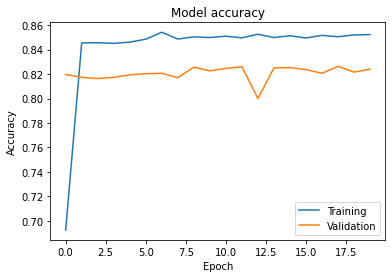

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

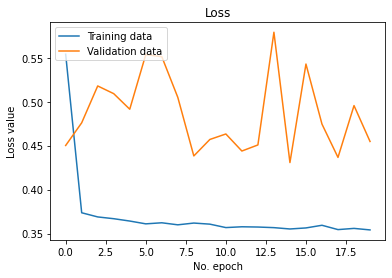

In [46]:
plt.plot(history.history['loss'], label='Training data')
plt.plot(history.history['val_loss'], label='Validation data')
plt.title('Loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()